# Adversarial bandits lab

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

### Definition of the parameters of the "Rock Paper Scissor" game

In [59]:
#Loss Matrix for the "Rock Paper Scissor" game
#1st dimension : rock
#2nd dimension : paper
#3rd dimension : scissor

M = 3
N = 3

L = - np.array(
    [[0,-1,1], 
     [1,0,-1], 
     [-1,1,0]])

### Implementation of EWA

In [3]:
def rand_exp(p):
  pop = [0, 1, 2]
  nb_output = 1
  output = random.choices(population = pop, k = nb_output, weights = p)
  return(output[0])

In [4]:
def EWA_update(p,l,eta):
    dim = len(p)
    p_future = np.zeros(dim)
    for i in range(dim):
        p_future[i] = p[i]*np.exp(-eta*l[i])/sum(p[j]*np.exp(-eta*l[j]) for j in range(M))
    return(p_future)

### Simulations : EWA againt a fixed strategy

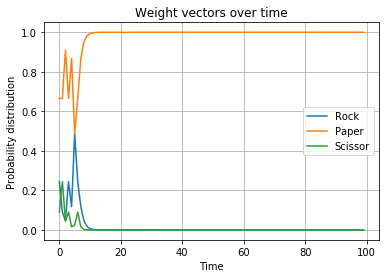

In [30]:
q = np.array([0.5, 0.25, 0.25]) #Fixed adversary strategy
p = np.array([1/3, 1/3, 1/3]) #Player strategy
eta = 1 #Learning parameter
T = 100 #Nb of game iterations

#Run nb_games iteration of the game with player_prob strategy distribution, adv_prob strategy distribution
#And with the learning rate eta
#The strategy of the adversary is fixed ! 
def run_game_fixed(nb_games, player_prob, adv_prob, eta):
    loss = np.zeros((nb_games,M)) #Loss tab for each game iteration
    l_t = np.zeros(nb_games) #Record the loss of the player for the action played (cumulative loss)
    r_t = np.zeros(nb_games) #Record the regret of the player for the action played (cumulative regret)
    weights = [] #Contains the weight vectors over time
    for i in range(nb_games):
        action_play = rand_exp(player_prob)
        action_adv = rand_exp(adv_prob)
        l_t[i] = L[action_play][action_adv]
        r_t[i] = L[action_play][action_adv] - L[1][action_adv]
        for j in range(M):
            loss[i][j] = L[j][action_adv]
        player_prob = EWA_update(player_prob, loss[i], eta)
        weights.append(player_prob)
    return(weights,l_t,r_t)

weights, l_t, r_t = run_game_fixed(T,p,q,eta)

fig, ax = plt.subplots()
ax.plot(weights)
ax.set(xlabel='Time', ylabel='Probability distribution', title='Weight vectors over time')
ax.grid()
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

The best strategy seems to play scissor all the time; indeed as the adversary will mostly play rock, we should choose the winning strategy against it: paper

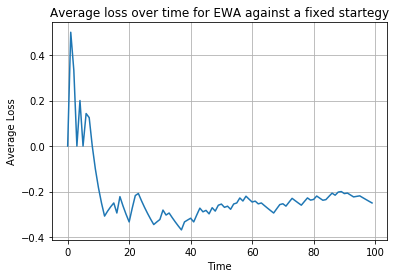

In [31]:
#Plot the average loss over time

def compute_avg_loss(l_t):
    dim = len(l_t)
    time = [i for i in range(dim)]
    avg_loss = [sum(l_t[:i])/(i+1) for i in range(dim)]
    return(time, avg_loss)

time, avg_loss = compute_avg_loss(l_t)

fig, ax = plt.subplots()
ax.plot(time, avg_loss)
ax.set(xlabel='Time', ylabel='Average Loss', title='Average loss over time for EWA against a fixed startegy')
ax.grid()
plt.show()

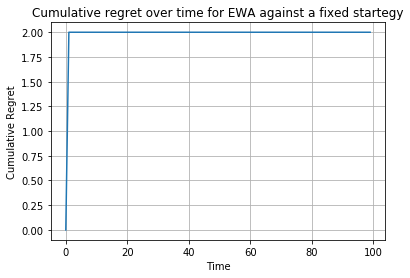

In [33]:
#Print the cumulative regret over time

def compute_cum_regret(r_t):
    dim = len(r_t)
    cum_regret = [sum(r_t[:i]) for i in range(dim)]
    return(cum_regret)

fig, ax = plt.subplots()
ax.plot(time, compute_cum_regret(r_t))
ax.set(xlabel='Time', ylabel='Cumulative Regret', title='Cumulative regret over time for EWA against a fixed startegy')
ax.grid()
plt.show()

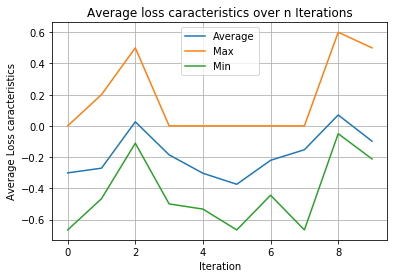

In [34]:
#Stability of the algorithm
n = 10
avg_loss_avg = []
avg_loss_max = []
avg_loss_min = []

for i in range(n):
    l_t = run_game_fixed(T,p,q,eta)[1]
    time, avg_loss = compute_avg_loss(l_t)
    avg_loss_avg.append(np.mean(avg_loss))
    avg_loss_max.append(max(avg_loss))
    avg_loss_min.append(min(avg_loss))
 
fig, ax = plt.subplots()
ax.plot(avg_loss_avg)
ax.plot(avg_loss_max)
ax.plot(avg_loss_min)
ax.set(xlabel='Iteration', ylabel='Average Loss caracteristics', title='Average loss caracteristics over n Iterations')
ax.grid()
plt.legend(('Average','Max', 'Min'))
plt.show()

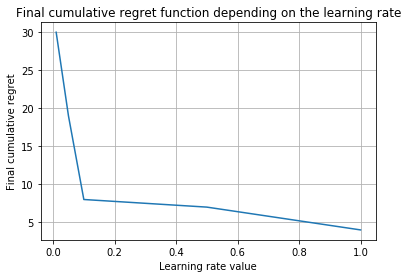

In [35]:
#Testing different value of Eta
eta_values = [0.01, 0.05, 0.1, 0.5, 1]
final_regret = np.zeros(len(eta_values))

for i in range(len(eta_values)):
    r_t = run_game_fixed(T,p,q,eta_values[i])[2]
    final_regret[i] = compute_cum_regret(r_t)[-1]

fig, ax = plt.subplots()
ax.plot(eta_values, final_regret)
ax.set(xlabel='Learning rate value', ylabel='Final cumulative regret', title='Final cumulative regret function depending on the learning rate')
ax.grid()
plt.show()

The best eta in pratice seems to be 0.5

# Full Information Feedback

### Simulations: EWA againt EWA 

In [36]:
#Adversary also playing EWA
q = np.array([0.5, 0.25, 0.25]) #Fixed adversary strategy
p = np.array([1/3, 1/3, 1/3]) #Player strategy
eta_player = 1 #Learning parameter
eta_adv = 0.05
T = 100 #Nb of game iterations

def run_game_EWA(nb_games, player_prob, adv_prob, eta_player, eta_adv):
    loss_play = np.zeros((nb_games,M)) #Player loss tab for each game iteration
    loss_adv = np.zeros((nb_games,M)) #Adversary loss tab for each game iteration
    l_t = np.zeros(nb_games) #Record the loss of the player for the action played (cumulative loss)
    weights_play = [] #Contains the weight vectors of the player over time
    weights_adv = [] #Contains the weight vectors of the adversary over time
    for i in range(nb_games):
        action_play = rand_exp(player_prob)
        action_adv = rand_exp(adv_prob)
        l_t[i] = L[action_play][action_adv]
        for j in range(M):
            loss_play[i][j] = L[j][action_adv]
            loss_adv[i][j] = L[action_adv][j]
        player_prob = EWA_update(player_prob, loss_play[i], eta_player)
        adv_prob = EWA_update(adv_prob, loss_adv[i], eta_adv)
        weights_play.append(player_prob)
        weights_adv.append(adv_prob)
    return(weights_play, weights_adv ,l_t)

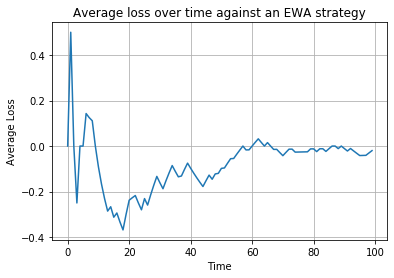

In [37]:
#Print the average loss over time

weights_play, weights_adv, l_t = run_game_EWA(T,p,q,eta_player,eta_adv)
time, avg_loss = compute_avg_loss(l_t)

fig, ax = plt.subplots()
ax.plot(time, avg_loss)
ax.set(xlabel='Time', ylabel='Average Loss', title='Average loss over time against an EWA strategy')
ax.grid()
plt.show()

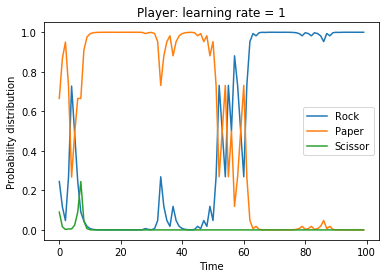

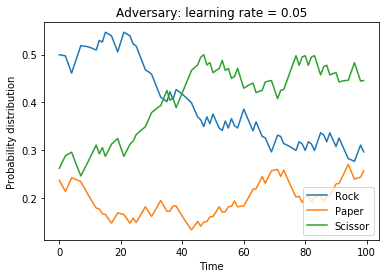

In [38]:
#Print the evolution of the weight vectors for both players
plt.plot(weights_play)
plt.xlabel('Time')
plt.ylabel('Probability distribution')
plt.title('Player: learning rate = 1')
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

plt.plot(weights_adv)
plt.xlabel('Time')
plt.ylabel('Probability distribution')
plt.title('Adversary: learning rate = 0.05')
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

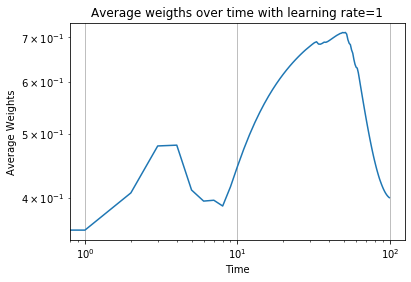

In [39]:
def compute_weight_average(weights):
    dim = len(weights)
    weights = np.array(weights)
    p_rock = weights[:,0]
    p_t_rock = [np.sum(p_rock[:i])/(i+1) - 1/3 for i in range(dim)]
    p_paper = weights[:,1]
    p_t_paper = [np.sum(p_paper[:i])/(i+1) - 1/3 for i in range(dim)]
    p_scissor = weights[:,2]
    p_t_scissor = [np.sum(p_scissor[:i])/(i+1) - 1/3 for i in range(dim)]
    
    p_t = np.array((p_t_rock, p_t_paper, p_t_scissor))
    p_t = np.transpose(p_t)
    p_avg = [np.linalg.norm(p_t[i]) for i in range(dim)]
    
    return(p_avg)

p_avg = compute_weight_average(weights_play)

fig, ax = plt.subplots()
ax.loglog(time, p_avg)
ax.set(xlabel='Time', ylabel='Average Weights', title='Average weigths over time with learning rate=1')
ax.grid()
plt.show()

# Bandit Feedback

### Implementation of EXP3

In [200]:
def estimated_loss(p, action, loss):
    est_loss = np.zeros(M)
    est_loss[action] = loss/p[action] 
    return(est_loss)

In [201]:
def EXP3_update(p, eta, loss_est):
    dim = len(p)
    p_future = np.zeros(dim)
    cum_loss_est = [sum(loss_est[:,i]) for i in range(M)]
    for i in range(dim):
        p_future[i] = np.exp(-eta*cum_loss_est[i])/sum(np.exp(-eta*cum_loss_est[j]) for j in range(M))
    return(p_future)

### Simulations : EXP3 against a fixed strategy

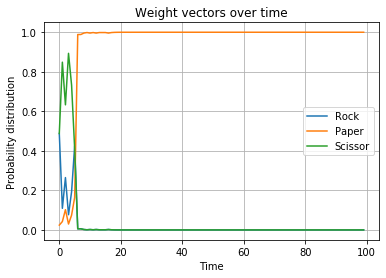

In [227]:
L_ = np.array(
    [[1/2,1,0], 
     [0,1/2,1], 
     [1,0,1/2]])

q = np.array([0.5, 0.25, 0.25]) #Fixed adversary strategy
p = np.array([1/3, 1/3, 1/3]) #Player strategy
eta = 1 #Learning parameter
T = 100 #Nb of game iterations

#Run nb_games iteration of the game with player_prob strategy distribution, adv_prob strategy distribution
#And with the learning rate eta
#The strategy of the adversary is fixed ! 
def run_game_EXP3_fixed(nb_games, player_prob, adv_prob, eta):
    l_t = np.zeros(nb_games) #Record the loss of the player for the action played (cumulative loss)
    r_t = np.zeros(nb_games) #Record the regret of the player for the action played (cumulative regret)
    weights = [] #Contains the weight vectors over time
    loss_est = np.zeros((nb_games,M)) #Contains the estimators over time
    for i in range(nb_games):
        action_play = rand_exp(player_prob)
        action_adv = rand_exp(adv_prob)
        l_t[i] = L_[action_play][action_adv]
        r_t[i] = L_[action_play][action_adv] - L_[1][action_adv]
        loss_est[i] = estimated_loss(player_prob, action_play, L[action_play][action_adv])
        player_prob = EXP3_update(player_prob, eta, loss_est)
        weights.append(player_prob)
    return(weights, l_t, r_t)

weights, l_t, r_t = run_game_EXP3_fixed(T,p,q,eta)

fig, ax = plt.subplots()
ax.plot(weights)
ax.set(xlabel='Time', ylabel='Probability distribution', title='Weight vectors over time')
ax.grid()
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

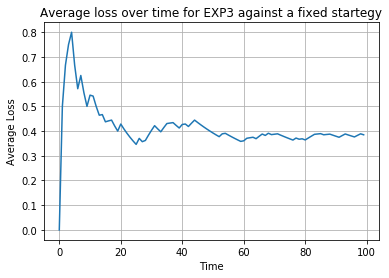

In [70]:
#Plot the average loss over time

def compute_avg_loss(l_t):
    dim = len(l_t)
    time = [i for i in range(dim)]
    avg_loss = [sum(l_t[:i])/(i+1) for i in range(dim)]
    return(time, avg_loss)

time, avg_loss = compute_avg_loss(l_t)

fig, ax = plt.subplots()
ax.plot(time, avg_loss)
ax.set(xlabel='Time', ylabel='Average Loss', title='Average loss over time for EXP3 against a fixed startegy')
ax.grid()
plt.show()

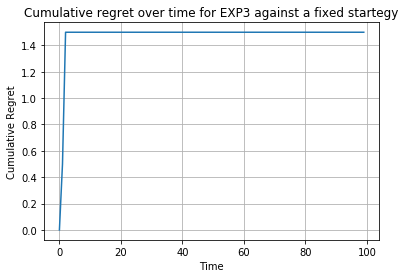

In [71]:
#Print the cumulative regret over time

def compute_cum_regret(r_t):
    dim = len(r_t)
    cum_regret = [sum(r_t[:i]) for i in range(dim)]
    return(cum_regret)

fig, ax = plt.subplots()
ax.plot(time, compute_cum_regret(r_t))
ax.set(xlabel='Time', ylabel='Cumulative Regret', title='Cumulative regret over time for EXP3 against a fixed startegy')
ax.grid()
plt.show()

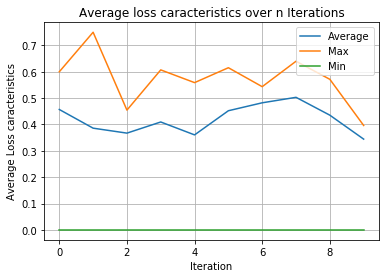

In [72]:
#Stability of the algorithm
n = 10
avg_loss_avg = []
avg_loss_max = []
avg_loss_min = []

for i in range(n):
    l_t = run_game_EXP3_fixed(T,p,q,eta)[1]
    time, avg_loss = compute_avg_loss(l_t)
    avg_loss_avg.append(np.mean(avg_loss))
    avg_loss_max.append(max(avg_loss))
    avg_loss_min.append(min(avg_loss))
 
fig, ax = plt.subplots()
ax.plot(avg_loss_avg)
ax.plot(avg_loss_max)
ax.plot(avg_loss_min)
ax.set(xlabel='Iteration', ylabel='Average Loss caracteristics', title='Average loss caracteristics over n Iterations')
ax.grid()
plt.legend(('Average','Max', 'Min'))
plt.show()

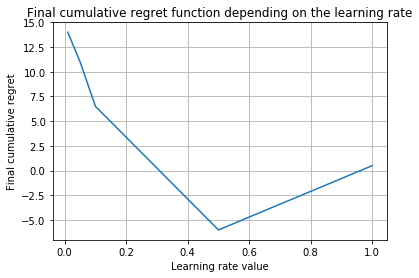

In [73]:
#Testing different value of Eta
eta_values = [0.01, 0.05, 0.1, 0.5, 1]
final_regret = np.zeros(len(eta_values))

for i in range(len(eta_values)):
    r_t = run_game_EXP3_fixed(T,p,q,eta_values[i])[2]
    final_regret[i] = compute_cum_regret(r_t)[-1]

fig, ax = plt.subplots()
ax.plot(eta_values, final_regret)
ax.set(xlabel='Learning rate value', ylabel='Final cumulative regret', title='Final cumulative regret function depending on the learning rate')
ax.grid()
plt.show()

### Simulations : EXP3 against EWA

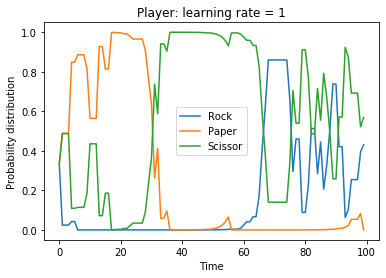

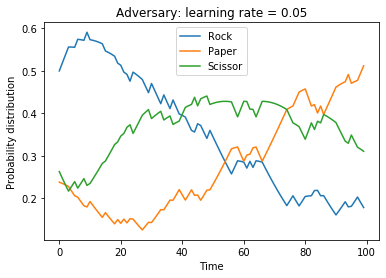

In [80]:
#Adversary also playing EWA
q = np.array([0.5, 0.25, 0.25]) #Fixed adversary strategy
p = np.array([1/3, 1/3, 1/3]) #Player strategy
eta_player = 1 #Learning parameter
eta_adv = 0.05
T = 100 #Nb of game iterations

def run_game_EXP3_EWA(nb_games, player_prob, adv_prob, eta_play, eta_adv):
    loss_adv = np.zeros((nb_games,M)) #Adversary loss tab for each game iteration
    l_t = np.zeros(nb_games) #Record the loss of the player for the action played (cumulative loss)
    weights_play = [] #Contains the weight vectors of the player over time
    weights_adv = [] #Contains the weight vectors of the adversary over time
    loss_est = np.zeros((nb_games,M)) #Contains the estimators over time
    for i in range(nb_games):
        action_play = rand_exp(player_prob)
        action_adv = rand_exp(adv_prob)
        l_t[i] = L_[action_play][action_adv]
        for j in range(M):
            loss_adv[i][j] = L[action_adv][j]
        
        loss_est[i] = estimated_loss(player_prob, action_play, L_[action_play][action_adv])
        player_prob = EXP3_update(player_prob, eta_play, loss_est)
        adv_prob = EWA_update(adv_prob, loss_adv[i], eta_adv)
        weights_play.append(player_prob)
        weights_adv.append(adv_prob)
    return(weights_play, weights_adv ,l_t)

weights_play, weights_adv, l_t = run_game_EXP3_EWA(T,p,q,eta_player,eta_adv)

#Print the evolution of the weight vectors for both players
plt.plot(weights_play)
plt.xlabel('Time')
plt.ylabel('Probability distribution')
plt.title('Player: learning rate = 1')
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

plt.plot(weights_adv)
plt.xlabel('Time')
plt.ylabel('Probability distribution')
plt.title('Adversary: learning rate = 0.05')
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()


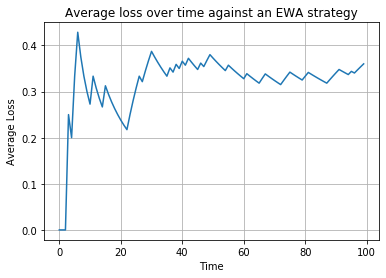

In [67]:
#Print the average loss over time

time, avg_loss = compute_avg_loss(l_t)

fig, ax = plt.subplots()
ax.plot(time, avg_loss)
ax.set(xlabel='Time', ylabel='Average Loss', title='Average loss over time against an EWA strategy')
ax.grid()
plt.show()

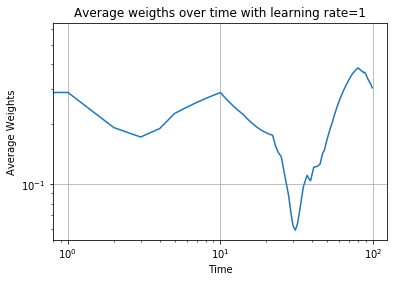

In [68]:
def compute_weight_average(weights):
    dim = len(weights)
    weights = np.array(weights)
    p_rock = weights[:,0]
    p_t_rock = [np.sum(p_rock[:i])/(i+1) - 1/3 for i in range(dim)]
    p_paper = weights[:,1]
    p_t_paper = [np.sum(p_paper[:i])/(i+1) - 1/3 for i in range(dim)]
    p_scissor = weights[:,2]
    p_t_scissor = [np.sum(p_scissor[:i])/(i+1) - 1/3 for i in range(dim)]
    
    p_t = np.array((p_t_rock, p_t_paper, p_t_scissor))
    p_t = np.transpose(p_t)
    p_avg = [np.linalg.norm(p_t[i]) for i in range(dim)]
    
    return(p_avg)

p_avg = compute_weight_average(weights_play)

fig, ax = plt.subplots()
ax.loglog(time, p_avg)
ax.set(xlabel='Time', ylabel='Average Weights', title='Average weigths over time with learning rate=1')
ax.grid()
plt.show()

### Optional Extensions

In [228]:
def estimated_loss_gamma(p, action, loss, gamma):
    est_loss = np.zeros(M)
    est_loss[action] = loss/(p[action] + gamma) 
    return(est_loss)

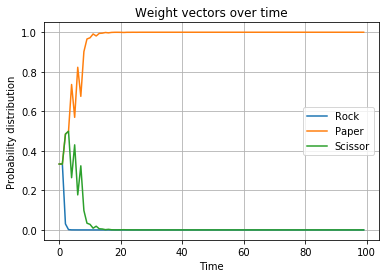

In [298]:
L_ = np.array(
    [[1/2,1,0], 
     [0,1/2,1], 
     [1,0,1/2]])

q = np.array([0.5, 0.25, 0.25]) #Fixed adversary strategy
p = np.array([1/3, 1/3, 1/3]) #Player strategy
eta = 1 #Learning parameter
T = 100 #Nb of game iterations
gamma = 1

#Run nb_games iteration of the game with player_prob strategy distribution, adv_prob strategy distribution
#And with the learning rate eta
#The strategy of the adversary is fixed ! 
def run_game_EXP3IX_fixed(nb_games, player_prob, adv_prob, eta, gamma):
    l_t = np.zeros(nb_games) #Record the loss of the player for the action played (cumulative loss)
    r_t = np.zeros(nb_games) #Record the regret of the player for the action played (cumulative regret)
    weights = [] #Contains the weight vectors over time
    loss_est = np.zeros((nb_games,M)) #Contains the estimators over time
    for i in range(nb_games):
        action_play = rand_exp(player_prob)
        action_adv = rand_exp(adv_prob)
        l_t[i] = L_[action_play][action_adv]
        r_t[i] = L_[action_play][action_adv] - L_[1][action_adv]
        loss_est[i] = estimated_loss_gamma(player_prob, action_play, L[action_play][action_adv], gamma)
        player_prob = EXP3_update(player_prob, eta, loss_est)
        weights.append(player_prob)
        eta = np.sqrt(np.log(M)/M*i)
        gamma = eta/2
    return(weights, l_t, r_t)

weights, l_t, r_t = run_game_EXP3IX_fixed(T,p,q,eta,gamma)

fig, ax = plt.subplots()
ax.plot(weights)
ax.set(xlabel='Time', ylabel='Probability distribution', title='Weight vectors over time')
ax.grid()
plt.legend(('Rock','Paper', 'Scissor'))
plt.show()

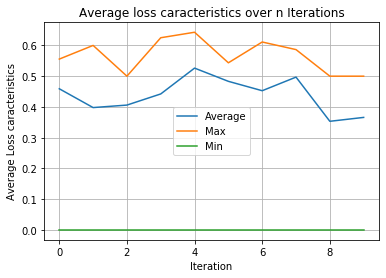

In [299]:
#Stability of the algorithm
n = 10
avg_loss_avg = []
avg_loss_max = []
avg_loss_min = []

for i in range(n):
    l_t = run_game_EXP3IX_fixed(T,p,q,eta,gamma)[1]
    time, avg_loss = compute_avg_loss(l_t)
    avg_loss_avg.append(np.mean(avg_loss))
    avg_loss_max.append(max(avg_loss))
    avg_loss_min.append(min(avg_loss))
 
fig, ax = plt.subplots()
ax.plot(avg_loss_avg)
ax.plot(avg_loss_max)
ax.plot(avg_loss_min)
ax.set(xlabel='Iteration', ylabel='Average Loss caracteristics', title='Average loss caracteristics over n Iterations')
ax.grid()
plt.legend(('Average','Max', 'Min'))
plt.show()